# Two Towers Model
- based on word2vec embeddings from gensim
- use a simple average of the word embeddings as the document embedding
- use a simple feedforward neural network as the encoder


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import wandb

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.collate import collate
from utils.load_data import load_word2vec
from utils.preprocess_str import str_to_tokens
from utils.checkpoint import save_checkpoint
from core import DocumentDataset, TwoTowerModel, loss_fn


[nltk_data] Downloading package stopwords to /Users/x25bd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/x25bd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# import inspect
# print(inspect.getsource(collate).split('\n', 1)[1].strip())

In [4]:
# import importlib
# import utils.checkpoint

# importlib.reload(utils.checkpoint)

In [26]:
# Define HYPERPARAMETERS
RANDOM_SEED = 42
FREEZE_EMBEDDINGS = True
VERBOSE = True
HIDDEN_DIM = 128
NUM_LAYERS = 1
MARGIN = 0.5
LEARNING_RATE = 0.00001
NUM_EPOCHS = 3
MODEL_NAME = "mlx-w2-two-tower-search"
PROJECTION_DIM = 64



In [6]:
# Load embeddings
vocab,embeddings, word_to_idx = load_word2vec()
embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=FREEZE_EMBEDDINGS)

EMBEDDING_DIM = embeddings.shape[1]
VOCAB_SIZE = len(vocab)

In [7]:
# Load training data
df = pd.read_parquet('../data/training.parquet')
df_validation = pd.read_parquet('../data/validation.parquet')
df_test = pd.read_parquet('../data/test.parquet')
# df = df.sample(n=10000, random_state=RANDOM_SEED)

In [8]:
def tokenize(df, word_to_idx):
    # Tokenize
    df.loc[:, 'doc_rel_tokens'] = df['doc_relevant'].apply(lambda x: str_to_tokens(x, word_to_idx))
    df.loc[:, 'doc_irr_tokens'] = df['doc_irrelevant'].apply(lambda x: str_to_tokens(x, word_to_idx))
    df.loc[:, 'query_tokens'] = df['query'].apply(lambda x: str_to_tokens(x, word_to_idx))
    return df


In [9]:
# Preprocess data

df = tokenize(df, word_to_idx)
# df['doc_rel_tkn_length'] = df['doc_rel_tokens'].apply(len)
# df['doc_irr_tkn_length'] = df['doc_irr_tokens'].apply(len)
# df['query_tkn_length'] = df['query_tokens'].apply(len)



In [11]:
df_full = df.copy()

In [12]:
df = df.sample(n=100000, random_state=RANDOM_SEED)


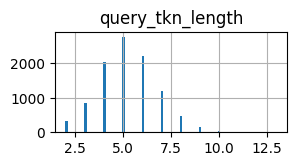

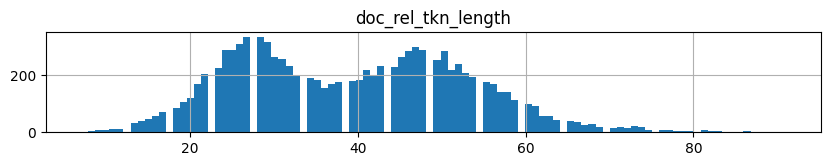

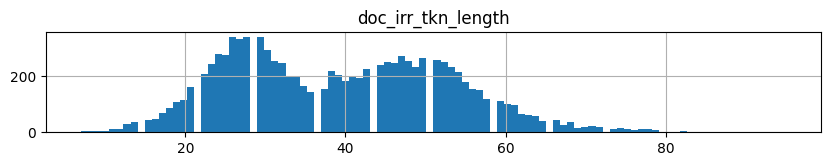

In [9]:
if VERBOSE:
    df[['query_tkn_length']].hist(bins=100, layout=(2,1), figsize=(3, 3))
    df[['doc_rel_tkn_length']].hist(bins=100, layout=(2,1), figsize=(10, 3))
    df[['doc_irr_tkn_length']].hist(bins=100, layout=(2,1), figsize=(10, 3))

In [13]:

# Create dataset and dataloader
dataset = DocumentDataset(df_full)

In [14]:

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate)

In [42]:
if VERBOSE:
    i = 0
    for docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask in dataloader:
        print('Batch', i + 1)
        print("Relevant Documents shape:", docs_rel.shape)
        print("Irrelevant Documents shape:", docs_irr.shape)
        print("Queries shape:", queries.shape)
        print("Relevant Document mask shape:", docs_rel_mask.shape)
        print("Irrelevant Document mask shape:", docs_irr_mask.shape)
        print("Query mask shape:", query_mask.shape)

        i += 1
        if i > 0:
            break  # Just print the first batch


Batch 1
Relevant Documents shape: torch.Size([32, 71])
Irrelevant Documents shape: torch.Size([32, 61])
Queries shape: torch.Size([32, 9])
Relevant Document mask shape: torch.Size([32, 71])
Irrelevant Document mask shape: torch.Size([32, 61])
Query mask shape: torch.Size([32, 9])


In [27]:
import importlib
import core

importlib.reload(core)
from core import TwoTowerModel, DocumentDataset, loss_fn

import utils.collate

importlib.reload(utils.collate)
from utils.collate import collate


In [49]:

# Create model
model = TwoTowerModel(embedding_dim=EMBEDDING_DIM, projection_dim=PROJECTION_DIM, embedding_layer=embedding_layer, margin=MARGIN)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



In [ ]:
if VERBOSE:
    model.eval()
    dataiter = iter(dataloader)
    docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask = next(dataiter)

    print("docs_rel.shape:", docs_rel.shape)
    print("docs_irr.shape:", docs_irr.shape)
    print("queries.shape:", queries.shape)
    print("docs_rel_mask.shape:", docs_rel_mask.shape)
    print("docs_irr_mask.shape:", docs_irr_mask.shape)
    print("query_mask.shape:", query_mask.shape)

    with torch.no_grad():
        similarity_rel = model(docs_rel, queries, doc_mask=docs_rel_mask, query_mask=query_mask)
        similarity_irr = model(docs_irr, queries, doc_mask=docs_irr_mask, query_mask=query_mask)
    similarity_rel, similarity_irr

    loss = loss_fn(similarity_rel, similarity_irr, MARGIN)
    print("Loss:", loss.item())

## Model Training

In [29]:
projection_dim_sweep = [24, 48, 96, 192]
margin_sweep = [0.1, 0.4, 0.7, 1.0]
lr_sweep = [LEARNING_RATE * i for i in [0.0001, 0.001, 0.01, 0.1, 1]]

In [18]:
# import importlib
# import wandb

# importlib.reload(wandb)
# import wandb


In [ ]:
for projection_dim in projection_dim_sweep:
    run_name = f"avg_pooling_projection_dim_{projection_dim}_commit_3799989"
    model = TwoTowerModel(embedding_dim=EMBEDDING_DIM, 
                          projection_dim=projection_dim, 
                          embedding_layer=embedding_layer, 
                          margin=MARGIN)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    wandb.init(project=MODEL_NAME, name=run_name)
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1} of {NUM_EPOCHS}")
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx % 1000 == 0:
                print(f"Batch {batch_idx + 1} of {len(dataloader)}")
            docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask = batch

            similarity_rel = model(docs_rel, queries, doc_mask=docs_rel_mask, query_mask=query_mask)
            similarity_irr = model(docs_irr, queries, doc_mask=docs_irr_mask, query_mask=query_mask)

            loss = loss_fn(similarity_rel, similarity_irr, MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()})
        save_checkpoint(model, epoch, run_name)
    wandb.finish()


In [ ]:
for margin in margin_sweep:
    run_name = f"avg_pooling_margin_{margin}_commit_3799989"
    model = TwoTowerModel(embedding_dim=EMBEDDING_DIM, projection_dim=PROJECTION_DIM, embedding_layer=embedding_layer, margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    wandb.init(project=MODEL_NAME, name=run_name)
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1} of {NUM_EPOCHS}")
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx % 1000 == 0:
                print(f"Batch {batch_idx + 1} of {len(dataloader)}")
            docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask = batch

            similarity_rel = model(docs_rel, queries, doc_mask=docs_rel_mask, query_mask=query_mask)
            similarity_irr = model(docs_irr, queries, doc_mask=docs_irr_mask, query_mask=query_mask)

            loss = loss_fn(similarity_rel, similarity_irr, MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()})
        save_checkpoint(model, epoch, MODEL_NAME)
        
    wandb.finish()


In [ ]:
for lr in lr_sweep:
    run_name = f"avg_pooling_learning_rate_{lr}_commit_3799989"
    model = TwoTowerModel(embedding_dim=EMBEDDING_DIM, projection_dim=PROJECTION_DIM, embedding_layer=embedding_layer, margin=MARGIN)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    wandb.init(project=MODEL_NAME, name=run_name)
    for epoch in range(NUM_EPOCHS):
        print('Learning Rate:', lr)
        print(f"Epoch {epoch + 1} of {NUM_EPOCHS}")
        for batch_idx, batch in enumerate(dataloader):
            if batch_idx % 5000 == 0:
                print(f"E{epoch + 1}: Batch {batch_idx + 1} of {len(dataloader)}")
            docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask = batch

            similarity_rel = model(docs_rel, queries, doc_mask=docs_rel_mask, query_mask=query_mask)
            similarity_irr = model(docs_irr, queries, doc_mask=docs_irr_mask, query_mask=query_mask)

            loss = loss_fn(similarity_rel, similarity_irr, MARGIN)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss.item()})
        save_checkpoint(model, epoch, run_name)
    wandb.finish()


In [32]:
model = TwoTowerModel(embedding_dim=EMBEDDING_DIM, projection_dim=PROJECTION_DIM, embedding_layer=embedding_layer, margin=MARGIN)

In [34]:
print(os.getcwd())

/Users/x25bd/Code/mlx/TwoTowerSearch/src/models


In [35]:
model.load_state_dict(torch.load(f'./checkpoints/avg_pooling_learning_rate_1e-05_commit_3799989_20241024_170821_epoch_3_3799989.pth'))

/var/folders/yr/gn_h4yzj0_9g3dttp_dn980r0000gn/T/ipykernel_70030/1876205184.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./checkpoi

<All keys matched successfully>

In [36]:
def validate(model, dataloader, margin):
    model.eval()
    total_loss = 0
    total_batches = 0
    
    with torch.no_grad():
        for batch in dataloader:
            docs_rel, docs_irr, queries, docs_rel_mask, docs_irr_mask, query_mask = batch
            
            similarity_rel = model(docs_rel, queries, doc_mask=docs_rel_mask, query_mask=query_mask)
            similarity_irr = model(docs_irr, queries, doc_mask=docs_irr_mask, query_mask=query_mask)
            
            loss = loss_fn(similarity_rel, similarity_irr, margin)
            total_loss += loss.item()
            total_batches += 1
    
    avg_loss = total_loss / total_batches
    return avg_loss

In [37]:

df_validation_sample = tokenize(df_validation.sample(n=1000, random_state=RANDOM_SEED), word_to_idx).reset_index(drop=True)


In [38]:
# Create validation dataset and dataloader
validation_dataset = DocumentDataset(df_validation_sample)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate)


In [39]:
validate(model, validation_dataloader, MARGIN)

0.1084432665957138

In [40]:
rel_doc = df_validation_sample.loc[0, 'doc_relevant']
irr_doc = df_validation_sample.loc[0, 'doc_irrelevant']
query = df_validation_sample.loc[0, 'query']

rel_doc_tokens = torch.tensor(df_validation_sample.loc[0, 'doc_rel_tokens'])
irr_doc_tokens = torch.tensor(df_validation_sample.loc[0, 'doc_irr_tokens'])
query_tokens = torch.tensor(df_validation_sample.loc[0, 'query_tokens'])

print(rel_doc_tokens.shape)
print(irr_doc_tokens.shape)
print(query_tokens.shape)


torch.Size([39])
torch.Size([27])
torch.Size([4])


In [41]:
model.eval()
with torch.no_grad():
    similarity_rel = model(rel_doc_tokens.unsqueeze(0), query_tokens.unsqueeze(0))
    similarity_irr = model(irr_doc_tokens.unsqueeze(0), query_tokens.unsqueeze(0))

similarity_rel, similarity_irr


(tensor([0.0569]), tensor([0.3039]))

In [42]:
query = "What are the effects of climate change?"
documents = [
    "Climate change is causing rising sea levels and more frequent extreme weather events.",
    "The Earth orbits around the Sun in an elliptical path.",
    "Global warming is leading to the melting of polar ice caps and glaciers.",
    "Photosynthesis is the process by which plants convert sunlight into energy.",
    "Increased greenhouse gas emissions are a major contributor to global climate change.",
    "The recipe for a classic Margherita pizza includes fresh mozzarella, tomatoes, and basil.",
    "The history of the Roman Empire is marked by significant military conquests and cultural achievements.",
    "Quantum mechanics explores the behavior of particles at the atomic and subatomic levels.",
    "The rules of chess involve strategic movement of pieces like the knight, bishop, and rook.",
    "The process of photosynthesis in plants involves converting carbon dioxide and water into glucose and oxygen using sunlight."
]


In [43]:
model.eval()
with torch.no_grad():
    # Tokenize and prepare the query
    query_tokens = torch.tensor([str_to_tokens(query, word_to_idx)])
    query_mask = (query_tokens != 0).float()

    # Tokenize and prepare the documents
    doc_tokens = [torch.tensor([str_to_tokens(doc, word_to_idx)]) for doc in documents]
    doc_masks = [(doc != 0).float() for doc in doc_tokens]

    # Calculate similarities
    similarities = []
    for doc, mask in zip(doc_tokens, doc_masks):
        similarity = model(doc, query_tokens, doc_mask=mask, query_mask=query_mask)
        similarities.append(similarity.item())

    # Sort documents by similarity
    ranked_docs = sorted(zip(documents, similarities), key=lambda x: x[1], reverse=True)



In [44]:
df_ranked_docs = pd.DataFrame(ranked_docs, columns=['Document', 'Similarity'])
df_ranked_docs['Query'] = query
df_ranked_docs = df_ranked_docs[['Query', 'Document', 'Similarity']]
pd.set_option('display.max_colwidth', None)

styled_df = df_ranked_docs.style.set_table_styles(
    {
        'Query': [{'selector': '', 'props': [('width', '150px')]}],
        'Document': [{'selector': '', 'props': [('width', '600px')]}]
    }
)

styled_df



,Query,Document,Similarity
0,What are the effects of climate change?,Climate change is causing rising sea levels and more frequent extreme weather events.,0.780167
1,What are the effects of climate change?,Global warming is leading to the melting of polar ice caps and glaciers.,0.613290
2,What are the effects of climate change?,Increased greenhouse gas emissions are a major contributor to global climate change.,0.560418
3,What are the effects of climate change?,The history of the Roman Empire is marked by significant military conquests and cultural achievements.,0.295092
4,What are the effects of climate change?,The Earth orbits around the Sun in an elliptical path.,0.274273
5,What are the effects of climate change?,Quantum mechanics explores the behavior of particles at the atomic and subatomic levels.,0.182102
6,What are the effects of climate change?,The process of photosynthesis in plants involves converting carbon dioxide and water into glucose and oxygen using sunlight.,0.066531
7,What are the effects of climate change?,Photosynthesis is the process by which plants convert sunlight into energy.,0.050126
8,What are the effects of climate change?,"The rules of chess involve strategic movement of pieces like the knight, bishop, and rook.",-0.067225
9,What are the effects of climate change?,"The recipe for a classic Margherita pizza includes fresh mozzarella, tomatoes, and basil.",-0.226395
